In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import torch
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, colors

In [3]:
from funcshape.testlib.surfaces import HyperbolicParaboloid, RotationDiffeomorphism

from funcshape.transforms import Qmap2D, SRNF
from funcshape.visual import (
    get_common_colornorm,
    plot_surface,
    plot_diffeomorphism_2d,
    save_surface_reparam,
    save_diffeomorphism_2d,
    save_error_plot
)
    

from funcshape.networks import SurfaceReparametrizer
from funcshape.layers.sinefourier import SineFourierLayer
from funcshape.loss import SurfaceDistance
from funcshape.reparametrize import reparametrize
from funcshape.logging import Logger

## Example 1: SRNF

[Iter     1] loss: 0.165732
[Iter     2] loss: 0.097262
[Iter     3] loss: 0.017536
[Iter     4] loss: 0.006590
[Iter     5] loss: 0.002814
[Iter     6] loss: 0.001789
[Iter     7] loss: 0.001651
[Iter     8] loss: 0.001410
[Iter     9] loss: 0.001344
[Iter    10] loss: 0.001143
[Iter    11] loss: 0.001092
[Iter    12] loss: 0.001041
[Iter    13] loss: 0.000999
[Iter    14] loss: 0.000956
[Iter    15] loss: 0.000890
[Iter    16] loss: 0.000792
[Iter    17] loss: 0.000758
[Iter    18] loss: 0.000708
[Iter    19] loss: 0.000678
[Iter    20] loss: 0.000637
[Iter    21] loss: 0.000593
[Iter    22] loss: 0.000557
[Iter    23] loss: 0.000517
[Iter    24] loss: 0.000491
[Iter    25] loss: 0.000472
[Iter    26] loss: 0.000440
[Iter    27] loss: 0.000410
[Iter    28] loss: 0.000393
[Iter    29] loss: 0.000367
[Iter    30] loss: 0.000355
[Iter    31] loss: 0.000341

Finished training in 4.35377s


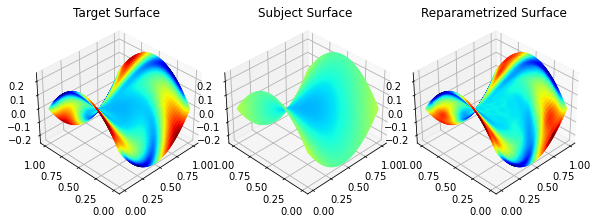

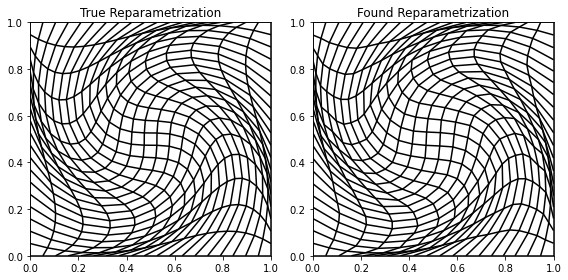

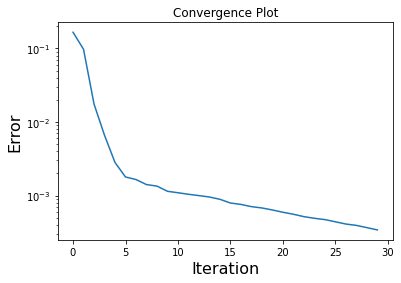

In [6]:
f = HyperbolicParaboloid()
γ = RotationDiffeomorphism()
g = f.compose(γ)
q = SRNF(g)
r = SRNF(f)

# Use GPU capabilities? Makes small differences for small networks,
# but is significantly more scalable.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# Define reparametrization-network
RN = SurfaceReparametrizer(
    [SineFourierLayer(10) for _ in range(10)]
).to(device)
loss_func = SurfaceDistance(q, r, k=32, h=None).to(device)

optimizer = optim.LBFGS(RN.parameters(), max_iter=30, line_search_fn="strong_wolfe")
errors = reparametrize(RN, loss_func, optimizer, 1, Logger(1))
RN.to("cpu"), loss_func.to("cpu"); # Need on CPU for plotting.
RN.detach()

# Reparametrize f
fafter = f.compose(RN)

# Define figure path for saving
path = "../figures/surface-reparametrization-srnf"

# Create Coloring Functions for plotting
k = 100 # Points per dimension (k^2 points total)
camera = (35, 225)
norm = get_common_colornorm((f, g, fafter), k=k)

save_surface_reparam(path, f, g, RN, camera, k)
save_error_plot(path, errors)
save_diffeomorphism_2d(path, γ, RN, k=20, clear=True)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

plot_surface(g, ax=ax1, k=k, colornorm=norm, camera=camera)
ax1.set_title("Target Surface")
plot_surface(f, ax=ax2, k=k, colornorm=norm, camera=camera)
ax2.set_title("Subject Surface")
plot_surface(fafter, ax=ax3, k=k, colornorm=norm, camera=camera)
ax3.set_title("Reparametrized Surface")
plt.tight_layout()
plt.show()

# Plot Diffeomorphisms. 
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
plot_diffeomorphism_2d(γ, k=20, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("True Reparametrization")

ax = fig.add_subplot(122)
plot_diffeomorphism_2d(RN, k=20, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Found Reparametrization")
plt.tight_layout()
plt.show()

plt.figure()
plt.semilogy(errors)
plt.axhline(0., ls="--", c="black")
plt.ylabel("Error", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.title("Convergence Plot")
plt.show()

## Example 2: Qmap 

In [7]:
from funcshape.testlib.surfaces import CylinderWrap, LogStepQuadratic

In [8]:
f = CylinderWrap()
γ = RotationDiffeomorphism().compose(LogStepQuadratic())
g = f.compose(γ)
q = Qmap2D(g)
r = Qmap2D(f)

# Use GPU capabilities? Makes small differences for small networks,
# but is significantly more scalable.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define reparametrization-network
RN = SurfaceReparametrizer(
    [SineFourierLayer(20) for _ in range(20)]
).to(device)
loss_func = SurfaceDistance(q, r, k=32, h=None).to(device)

optimizer = optim.LBFGS(RN.parameters(), max_iter=30, line_search_fn="strong_wolfe")
errors = reparametrize(RN, loss_func, optimizer, 1, Logger(1))
RN.to("cpu"), loss_func.to("cpu"); # Need on CPU for plotting.
RN.detach()

# Reparametrize f
fafter = f.compose(RN)

[Iter     1] loss: 13.149002
[Iter     2] loss: 11.829178
[Iter     3] loss: 10.149688
[Iter     4] loss: 7.383197
[Iter     5] loss: 5.874188
[Iter     6] loss: 4.112458
[Iter     7] loss: 3.383172
[Iter     8] loss: 2.633549
[Iter     9] loss: 2.068196
[Iter    10] loss: 1.434879
[Iter    11] loss: 1.119194
[Iter    12] loss: 0.844584
[Iter    13] loss: 0.626900
[Iter    14] loss: 0.533355
[Iter    15] loss: 0.376767
[Iter    16] loss: 0.266606
[Iter    17] loss: 0.214882
[Iter    18] loss: 0.175762
[Iter    19] loss: 0.135499
[Iter    20] loss: 0.106008
[Iter    21] loss: 0.090138
[Iter    22] loss: 0.071150
[Iter    23] loss: 0.064845
[Iter    24] loss: 0.043463
[Iter    25] loss: 0.032813
[Iter    26] loss: 0.024435
[Iter    27] loss: 0.020977
[Iter    28] loss: 0.017502
[Iter    29] loss: 0.013479
[Iter    30] loss: 0.011522
[Iter    31] loss: 0.010226

Finished training in 15.54243s


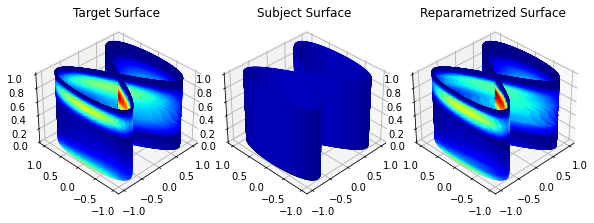

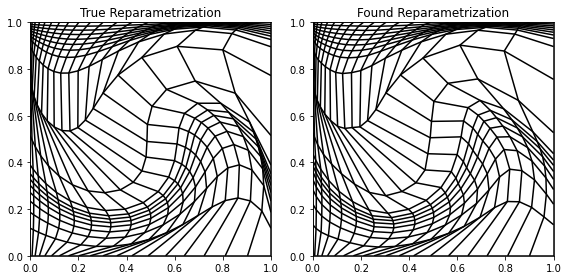

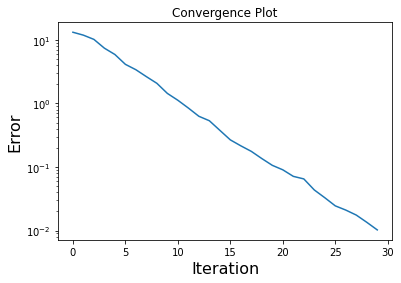

In [12]:
# Define figure path for saving
path = "../figures/surface-reparametrization-qmap"

# Create Coloring Functions for plotting
k = 256 # Points per dimension (k^2 points total)
camera = (35, 225)
norm = get_common_colornorm((f, g, fafter), k=k)

save_surface_reparam(path, f, g, RN, camera, k)
save_error_plot(path, errors)
save_diffeomorphism_2d(path, γ, RN, k=24, clear=True)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
                        
plot_surface(g, ax=ax1, k=k, colornorm=norm, camera=camera)
plot_surface(f, ax=ax2, k=k, colornorm=norm, camera=camera)
plot_surface(fafter, ax=ax3, k=k, colornorm=norm, camera=camera)
ax1.set_title("Target Surface")
ax2.set_title("Subject Surface")
ax3.set_title("Reparametrized Surface")
plt.tight_layout()
plt.show()

# Plot Diffeomorphisms. 
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
plot_diffeomorphism_2d(γ, k=20, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("True Reparametrization")

ax = fig.add_subplot(122)
plot_diffeomorphism_2d(RN, k=20, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Found Reparametrization")
plt.tight_layout()
plt.show()

plt.figure()
plt.semilogy(errors)
plt.axhline(0., ls="--", c="black")
plt.ylabel("Error", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.title("Convergence Plot")
plt.show()